# Project Topic: Recommendation system for Amazon Products using Collaborative Filtering


Data Source: Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/). 
We are using the Electronics dataset.

# 1. Importing required libraries

In [2]:
import numpy as np 
import pandas as pd 
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import statistics
import json
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
# import networkx as nx
#import igraph as ig
import statistics
import matplotlib.pyplot as plt; plt.rcdefaults()

# 2. Loading dataset

In [3]:
df = pd.read_csv ('electronics.csv')
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [4]:
# Adding column names
df.columns = ['userId', 'productId', 'Rating', 'timestamp']
# Dropping the timestamp column
df = df.drop('timestamp', axis=1)

In [5]:
# Viewing data 
df.head()

,userId,productId,Rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [6]:
#gives unique number of items and users
n_users = df.userId.unique().shape[0]
n_items = df.productId.unique().shape[0]

print('No. of unique users: ', n_users)
print('No, of unique products: ', n_items)

No. of unique users:  4201696
No, of unique products:  476001


In [7]:
# Since the data is very big, we're taking 200000 rows
df = df.head(200000)

In [8]:
#gives unique number of items and users in smaller dataset
n_users = df.userId.unique().shape[0]
n_items = df.productId.unique().shape[0]

print('No. of unique users: ', n_users)
print('No, of unique products: ', n_items)

No. of unique users:  173349
No, of unique products:  13130


# 3. Data exploration

### Plotting the users-products bipartite graph

The nodes can be divided into two sets, one set for the users and the other for the products. 
Edges exist only between a user and a product if it has been purchased by the user.

<img src = "social_network.png">




### Analysis of Dataset

In [9]:
# Checking for missing values
print('Number of missing values across columns: \n',df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
dtype: int64


<BarContainer object of 20 artists>

Text(0, 0.5, 'No of ratings')

Text(0.5, 1.0, 'Most popular')

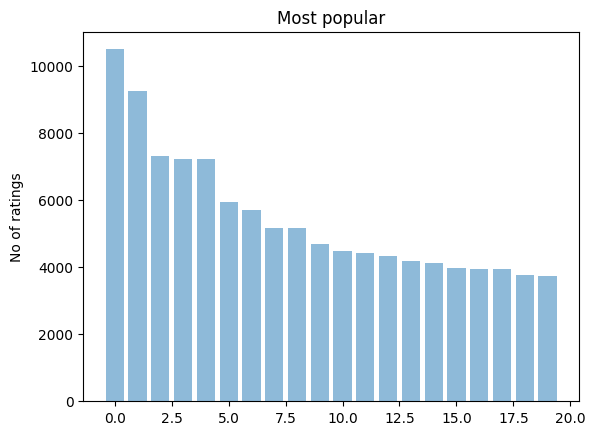

In [10]:
# Most popular products
popular = df[['productId','Rating']].groupby('productId').sum().reset_index()
popular_20 = popular.sort_values('Rating', ascending=False).head(n=20)

objects = (list(popular_20['productId']))
y_pos = np.arange(len(objects))
performance = list(popular_20['Rating'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
#plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('No of ratings')
plt.title('Most popular')
 
plt.show()

In [11]:
# Number of products rated per user

ratings_per_user = df.groupby('userId')['Rating'].count()
ratings_per_user = pd.DataFrame(ratings_per_user)
ratings_per_user.sort_values(by=ratings_per_user.columns[0], inplace = True)
ratings_per_user.rename(columns = {'Rating': 'No. of products rated'}, inplace = True)
print(ratings_per_user)
ratings_per_user.rename(columns = {'No. of products rated':'Rating'}, inplace = True)

print('\nAvg no of ratings per user: ', statistics.mean(ratings_per_user[ratings_per_user.columns[0]].tolist()))
 

                       No. of products rated
userId                                      
A001944026UMZ8T3K5QH1                      1
A3GI8FXR819KJ                              1
A3GI9F4A52DROO                             1
A3GIA221CVY1A1                             1
A3GIAHV5UYGC9                              1
...                                      ...
AT2J7H5TRZM8Z                             53
A2BGZ52M908MJY                            54
A25HBO5V8S8SEA                            72
A5JLAU2ARJ0BO                             86
A231WM2Z2JL0U3                           192

[173349 rows x 1 columns]

Avg no of ratings per user:  1.1537418733306797


### Distribution of ratings per user

array([[<AxesSubplot:title={'center':'Rating'}>]], dtype=object)

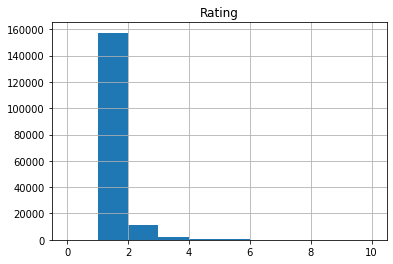

In [12]:
# distribution of ratings per user
%matplotlib inline
ratings_per_user.hist(bins=10, range=(0,10))

In [13]:
# Number of ratings per product
ratings_per_product = df.groupby('productId')['Rating'].count()
ratings_per_product = ratings_per_product.to_frame()
ratings_per_product.sort_values(by=ratings_per_product.columns[0], inplace = True)
ratings_per_product.rename(columns = {'Rating': 'No. of ratings recieved'}, inplace = True)
print(ratings_per_product)
ratings_per_product.rename(columns = {'No. of ratings recieved':'Rating'}, inplace = True)

print('\nAvg no of ratings per product: ', statistics.mean(ratings_per_product[ratings_per_product.columns[0]].tolist()))

            No. of ratings recieved
productId                          
0321732944                        1
B00005A3LF                        1
B00005A0R9                        1
B00005A0R7                        1
B000059Z88                        1
...                             ...
B00001WRSJ                     1586
B00004T8R2                     1692
B000065BP9                     1714
B00001P4ZH                     2075
B00004ZCJE                     2547

[13130 rows x 1 columns]

Avg no of ratings per product:  15.232292460015232


### Distribution of ratings per product

array([[<AxesSubplot:title={'center':'Rating'}>]], dtype=object)

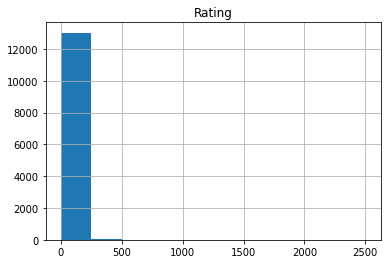

In [14]:
# distribution of ratings per product
%matplotlib inline
ratings_per_product.hist(bins=10, range=(0,2500))

### Analysis for the Ratings

In [15]:
#Summary statistics of rating variable
df['Rating'].describe().transpose()

count    200000.000000
mean          4.013895
std           1.373682
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

In [16]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df.Rating.min()))
print('Maximum rating is: %d' %(df.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


<AxesSubplot:xlabel='Rating', ylabel='count'>

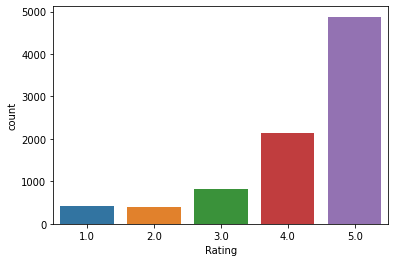

In [57]:
# Check the distribution of the rating
sns.countplot(x = df.Rating)

# 4. Taking a subset of the dataset 
To make it less sparse

In [18]:
# Removing products if < 10 ratings
filtered_ratings_per_product = ratings_per_product[ratings_per_product.Rating >= 10]
# build a list of productsId to keep
popular_products = filtered_ratings_per_product.index.tolist()

In [19]:
# Removing users if < 5 ratings
filtered_ratings_per_user = ratings_per_user[ratings_per_user.Rating >= 5]
# build a list of UserId to keep
popular_users = filtered_ratings_per_user.index.tolist()

In [20]:
filtered_ratings = df[df.productId.isin(popular_products)]
filtered_ratings = df[df.userId.isin(popular_users)]
print('Rows in filtered matrix:', len(filtered_ratings))

Rows in filtered matrix: 8659


In [21]:
df = filtered_ratings
filtered_ratings.head()

,userId,productId,Rating
117,AT09WGFUM934H,0594481813,3.0
388,A6J8D9V5S9MBE,0972683275,5.0
630,A3TAS1AG6FMBQW,0972683275,5.0
1044,ABU4LUKJU2QOY,0972683275,5.0
1309,A3LDPF5FMB782Z,1400501466,5.0


In [22]:
#gives unique number of items and users
n_users = df.userId.unique().shape[0]
n_items = df.productId.unique().shape[0]

print('No. of unique users: ', n_users)
print('No, of unique products: ', n_items)

No. of unique users:  1067
No, of unique products:  3978


# 5. Splitting the data

In [23]:
#Split the data randomnly into train and test datasets into 70:30 ratio

train_data, test_data = train_test_split(df, test_size = 0.3, random_state=0)

print(train_data.head())
print(test_data.head())
print('\n\n')
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

                userId   productId  Rating
84162    A41JUIFTT1J4B  B000054453     5.0
113050  A231WM2Z2JL0U3  B00005OMZN     3.0
47713   A1MJMYLRTZ76ZX  B00004TDN2     5.0
187553  A181WZ2IC9JQNC  B00006HYKM     5.0
70443   A3V3JVJ9NJYBBI  B00004ZB57     5.0
                userId   productId  Rating
11513    AEFRJ6ZBKGZV2  B00000J1VT     4.0
183915  A2AEZQ3DGBBLPR  B00006HQEI     1.0
188105   AV15W3FPLQPN0  B00006HYPU     5.0
81237   A2QXLAXAS84F1Y  B000051SDS     3.0
38337   A2EDFATBY4VNTS  B00004S9AK     5.0



Shape of training data:  (6061, 3)
Shape of testing data:  (2598, 3)


# 6. Memory Based User-Item Collaborative Filtering


## Method 1: Using cosine similarity formula

In [24]:
# Creating pivot tables for both training and test datasets
train_matrix = train_data.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
test_matrix = test_data.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)

In [25]:
train_matrix.head()

productId,0594481813,0972683275,1400501466,1400501776,140053271X,1400599997,1400698987,7040034018,9043413585,9623499043,...,B00006JK37,B00006JKWE,B00006JKXN,B00006JLOS,B00006JLOT,B00006JLWJ,B00006JM1W,B00006JM5T,B00006JN2R,B00006JN3G
userId,,,,,,,,,,,,,,,,,,,,,
A101OAAMZYWQ3U,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1027EV8A9PV1O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10C84Y38RT22P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10DIDVYDN2Q5Z,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10KFV763ZTT0T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
train_matrix_np = train_matrix.values
test_matrix_np = test_matrix.values
print(train_matrix_np.shape)
print(test_matrix_np.shape)

(1064, 3175)
(938, 1778)


In [27]:
# #Mapping userIds to indices in test matrix (for predictions)
# test_matrix2 = test_matrix
# test_matrix2['user_index'] = np.arange(0, test_matrix2.shape[0], 1)
# test_matrix2.set_index(['user_index'], inplace=True)
# test_matrix2.head()
# l1 = test_matrix2.columns.tolist()

#Mapping userIds to indices in test matrix (for predictions)
train_matrix2 = train_matrix
train_matrix2['user_index'] = np.arange(0, train_matrix2.shape[0], 1)
train_matrix2.set_index(['user_index'], inplace=True)
train_matrix2.head()
l1 = train_matrix2.columns.tolist()

productId,0594481813,0972683275,1400501466,1400501776,140053271X,1400599997,1400698987,7040034018,9043413585,9623499043,...,B00006JK37,B00006JKWE,B00006JKXN,B00006JLOS,B00006JLOT,B00006JLWJ,B00006JM1W,B00006JM5T,B00006JN2R,B00006JN3G
user_index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
#Calucating the density of the train marix
given_num_of_ratings = np.count_nonzero(train_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = df.shape[0] * train_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.5f}%'.format(density))

given_num_of_ratings =  6061
possible_num_of_ratings =  27492325
density: 0.02205%


In [29]:
# Using the cosine similarity metric
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_matrix_np, metric='cosine')

#### Pairwise distances:
#### This method takes a vector array and returns a distance matrix.

Similarity is calculated using:

<img src="https://miro.medium.com/max/1050/1*V8ZXwnclxmxfS8xL0Re6Tw.png">

In [30]:
# User based CF predictions
def predict(ratings, similarity, type='user'):
    mean_user_rating = ratings.mean(axis=1)
    #Used np.newaxis so that mean_user_rating has same format as ratings
    ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
    pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

#### To combine our similarity matrix with users' past history of rated items to generate a recommendation
<img src = "https://miro.medium.com/max/2166/1*KgjK4weByito-VShQKnSmA.png">



In [31]:
# Running prediction function
user_prediction = predict(train_matrix_np, user_similarity, type='user')

In [32]:
user_prediction_df = pd.DataFrame(user_prediction)
print("Predictions matrix")
user_prediction_df.head()

Predictions matrix


,0,1,2,3,4,5,6,7,8,9,...,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174
0,-0.000040,0.011253,0.006548,0.001843,0.007489,0.008430,0.000901,0.001843,-0.000040,0.001843,...,0.006548,0.001843,0.016899,0.009371,0.004666,-0.000981,0.000901,0.000901,0.000901,0.033838
1,0.000905,0.012210,0.007499,0.002789,0.008441,0.009384,0.001847,0.002789,0.000905,0.002789,...,0.007499,0.002789,0.017862,0.010326,0.005615,-0.000037,0.001847,0.001847,0.001847,0.034819
2,0.009422,0.020726,0.016016,0.011306,0.016958,0.017900,0.010364,0.011306,0.009422,0.011306,...,0.016016,0.011306,0.026249,0.018842,0.014132,0.008480,0.010364,0.010364,0.010364,0.042744
3,-0.001618,0.009685,0.004975,0.000266,0.005917,0.006859,-0.000676,0.000266,-0.001618,0.000266,...,0.004975,0.000266,0.015336,0.007801,0.003091,-0.002560,-0.000676,-0.000676,-0.000676,0.032290
4,-0.001618,0.009684,0.004975,0.000265,0.005917,0.006858,-0.000676,0.000265,-0.001618,0.000265,...,0.004975,0.000265,0.015335,0.007800,0.003091,-0.002560,-0.000676,-0.000676,-0.000676,0.032289


In [33]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations, l1):
    # index starts at 0  
    user_idx = userID - 1 

    print('userid: ', user_idx)
    user_predictions = preds_df.loc[user_idx, :]
    sorted_user_predictions = user_predictions.sort_values(ascending=False)
    #print(sorted_user_predictions)
    
    temp = pd.DataFrame(sorted_user_predictions)
    temp.columns = ['Predicted rating']
    temp = temp.head(num_recommendations)
    
    final = list()
    l2 = temp.index.tolist()
    for i in l2:
        pid = l1[i]
        final.append(pid)
        
    temp.index = final
    temp.index.name = 'Recommended Items'
    print(temp)

In [34]:
recommend_items(99, train_matrix2, user_prediction_df, 5, l1)

userid:  98
                   Predicted rating
Recommended Items                  
B00004SB92                 0.236779
B00003G1RG                 0.134716
B000031KIM                 0.111813
B00005ARK3                 0.102943
B00004RC2D                 0.099679


### Evaluation of result

<img src="https://camo.githubusercontent.com/ddf775a23d88bc62ad438a7266011ecbcc6c7b96/68747470733a2f2f6c617465782e636f6465636f67732e636f6d2f6769662e6c617465783f524d53452673706163653b3d5c737172747b5c667261637b317d7b4e7d2673706163653b5c73756d2673706163653b28785f692673706163653b2d5c6861747b785f697d295e327d">

In [35]:
# Function to calculate RMSE for predictions
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [36]:
print ('User-based CF RMSE: ' + str(rmse(user_prediction, test_matrix_np)))

User-based CF RMSE: 4.3638712861104105


## Method 2

In [37]:
#new_df = df.head(10000)
ratings_matrix = df.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0594481813,0972683275,1400501466,1400501520,1400501776,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00006JKWE,B00006JKWZ,B00006JKXN,B00006JLOS,B00006JLOT,B00006JLWJ,B00006JM1W,B00006JM5T,B00006JN2R,B00006JN3G
userId,,,,,,,,,,,,,,,,,,,,,
A101OAAMZYWQ3U,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1027EV8A9PV1O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10C84Y38RT22P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10DIDVYDN2Q5Z,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10KFV763ZTT0T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Creating a function to find the 3 most similar users to the current_user using cosine similarity

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
import operator
def similar_users(userId, matrix, k=3):
    # create a df of just the current user
    user = matrix[matrix.index == userId]
    
    # and a df of all other users
    other_users = matrix[matrix.index != userId]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    # create list of indices of these users
    indices = other_users.index.tolist()
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indices, similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_similarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_similarities]
    
    return users

In [39]:
current_user = 'A12OAW0LAY5IFX'
similar_user_indices = similar_users(current_user, ratings_matrix)
print(similar_user_indices)

['A1SDIQSV4EMCES', 'A48K4NKMK9X4P', 'A15V0W7UZW0I9V']


In [40]:
def recommend_item(user_index, similar_user_indices, matrix, items=5):
    
    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    
    # calc avg ratings across the 3 similar users
    similar_users = similar_users.mean(axis=0)
    
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    
    # remove any rows without a 0 value (products not rated yet)
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    
    # generate a list of products the user has not seen
    products_unseen = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only products the current user has not seen
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(products_unseen)]
    
    # order the dataframe
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    
    # grab the top n products 
    top_n_product = similar_users_df_ordered.head(items)
    top_n_product_indices = top_n_product.index.tolist()
    
    return top_n_product_indices #items


In [41]:
#Finding recommendations (top 5) for a paticular user
current_user = 'A12OAW0LAY5IFX'
recommend_item(current_user, similar_user_indices, ratings_matrix)

['B0000633DU', 'B0000630TO', 'B0000633DX', 'B0000630TQ', 'B00006BT1W']

# 7. Model-Based Collaborative Filtering (using SVD)

 


In [42]:
#define user index from 0 to 10
ratings_matrix['user_index'] = np.arange(0, ratings_matrix.shape[0], 1)
ratings_matrix.head()

productId,0594481813,0972683275,1400501466,1400501520,1400501776,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00006JKWZ,B00006JKXN,B00006JLOS,B00006JLOT,B00006JLWJ,B00006JM1W,B00006JM5T,B00006JN2R,B00006JN3G,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A101OAAMZYWQ3U,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1027EV8A9PV1O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
A10C84Y38RT22P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
A10DIDVYDN2Q5Z,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
A10KFV763ZTT0T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [43]:
ratings_matrix.shape

(1067, 3979)

In [44]:
#Replacing userId with indices
ratings_matrix.set_index(['user_index'], inplace=True)
# Actual ratings given by users
ratings_matrix.head()

productId,0594481813,0972683275,1400501466,1400501520,1400501776,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00006JKWE,B00006JKWZ,B00006JKXN,B00006JLOS,B00006JLOT,B00006JLWJ,B00006JM1W,B00006JM5T,B00006JN2R,B00006JN3G
user_index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
#Converting ratings to float type
ratings_matrix = ratings_matrix.astype(float)

In [46]:
# Singular Value Decomposition
U, sigma, Vt = svds(ratings_matrix, k = 10)

<img src="http://cdn.app.compendium.com/uploads/user/e7c690e8-6ff9-102a-ac6d-e4aebca50425/f4a5b21d-66fa-4885-92bf-c4e81c06d916/Image/229f77d2cb173c1cef4d6cfbab2e905e/svd_matrices.jpg">

<img src = "https://hackernoon.com/hn-images/1*haUDjEiQmG0RapR0SHos6Q.png">

In [47]:
# Converting sigma to diagonal matrix
sigma = np.diag(sigma)

In [48]:
print('Left singular matrix: \n',U)

print('\n\n Sigma: \n',sigma)

print('\n\ Right singular matrix: \n',Vt)

Left singular matrix: 
 [[-7.24911891e-05 -6.02058913e-04 -3.11590718e-04 ... -2.38558743e-04
   1.19349501e-03  2.24265544e-04]
 [ 1.02590050e-03 -2.38256524e-02  1.29376747e-03 ...  4.85668552e-04
   1.80951162e-03  6.82142121e-04]
 [ 6.01905058e-03 -1.04088979e-02  1.60425787e-03 ... -4.22339006e-04
   2.57017136e-03  7.88106006e-03]
 ...
 [-2.27866228e-03  2.05776602e-03  3.83675430e-03 ... -1.03126113e-02
   5.99013436e-02  2.34937295e-02]
 [-5.94927174e-03  6.37914682e-03  9.53462229e-04 ... -1.24120252e-02
   8.54639098e-02  2.54217221e-02]
 [-7.60370656e-05 -2.97836222e-03 -4.50039805e-04 ... -5.25507225e-06
   3.83031426e-04  9.53536839e-05]]


 Sigma: 
 [[31.47252614  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         31.75502471  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         32.36915084  0.          0.          0.
   0.          0.          0

In [49]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_matrix.columns)
preds_df.head()

productId,0594481813,0972683275,1400501466,1400501520,1400501776,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00006JKWE,B00006JKWZ,B00006JKXN,B00006JLOS,B00006JLOT,B00006JLWJ,B00006JM1W,B00006JM5T,B00006JN2R,B00006JN3G
0,0.000014,1.506132e-04,0.000066,0.000011,0.000011,-0.000309,0.000820,0.000011,-0.000030,0.000009,...,0.000155,0.000076,-0.001751,0.001386,-0.000114,-0.000293,-0.000633,0.000006,-0.000633,-0.002165
1,0.000405,2.429232e-03,0.001871,0.000062,0.000062,-0.000877,0.000780,0.000440,0.000362,0.000049,...,0.002692,0.001401,-0.008848,0.001049,0.002795,-0.013447,0.001904,0.000076,0.001904,0.007676
2,0.000205,1.184825e-03,0.000786,0.000026,0.000026,0.009725,0.001063,0.000188,-0.000103,0.000021,...,0.001199,0.000663,0.024779,0.000036,0.006659,0.022065,0.007676,0.000068,0.007676,0.062463
3,0.000035,2.377466e-04,0.000086,0.000009,0.000009,-0.000483,0.000572,0.000019,-0.000116,0.000007,...,0.000253,0.000128,0.000494,0.001090,0.000299,0.004103,-0.001748,0.000009,-0.001748,-0.001273
4,0.000391,-1.764686e-07,-0.001005,-0.000080,-0.000080,-0.001495,-0.001986,0.000032,-0.001911,-0.000064,...,0.011086,0.000302,0.018306,-0.002378,-0.003810,0.000921,0.011966,0.000091,0.011966,0.136514


In [50]:
preds_df.shape

(1067, 3978)

In [51]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #print(sorted_user_ratings)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #print(sorted_user_predictions)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [52]:
userID = 9
num_recommendations = 5
recommend_items(userID, ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B00004SB92                  0.0          0.276637
B00004ZCJE                  0.0          0.157766
B00004Z5M1                  0.0          0.064820
B00001W0DI                  0.0          0.064095
B00006B7HB                  0.0          0.061994


In [53]:
userID = 100
num_recommendations = 5
recommend_items(userID, ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 100):

                   user_ratings  user_predictions
Recommended Items                                
B00005LEN4                  0.0          0.626782
B000031KIM                  0.0          0.507470
B00004TDN2                  0.0          0.364728
B00005Y1Z6                  0.0          0.359981
B000053HH5                  0.0          0.359014


In [54]:
userID = 20
num_recommendations = 5
recommend_items(userID, ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B00004ZCJE                  0.0          0.136136
B00005ARK3                  0.0          0.106266
B00006HYKM                  0.0          0.098032
B00006B7HB                  0.0          0.094819
B00004VX3T                  0.0          0.089562


### Evaluation of result

In [55]:
rmse_df = pd.concat([ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(3978, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0594481813,0.002812,0.000301,0
0972683275,0.014058,0.001461,1
1400501466,0.009372,0.000698,2
1400501520,0.004686,0.000044,3
1400501776,0.004686,0.000044,4


In [56]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE of the SVD Model = {} \n'.format(RMSE))


RMSE of the SVD Model = 0.00712 

